In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from adjustText import adjust_text
from statannot import add_stat_annotation

import pandas as pd
import seaborn as sns
import os
import re

import pickle
import json

In [2]:
def set_aspect_ratio(ax):
    
    """
    helper function to make square axes with equal x and y ranges
    """
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    both_min = np.min([xmin, ymin])
    both_max = np.max([xmax, ymax])
    ax.set_xlim((both_min, both_max))
    ax.set_ylim((both_min, both_max))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    return ax
    
def same_ticks(ax):
    
    # Make ticks the same
    ax.set_xticks(ax.get_yticks())
    ax.set_xticklabels([aa.get_text() for aa in ax.get_yticklabels()])
    
    return ax

In [3]:
data_dir = './eye_tracking_data/'

In [4]:
print(len(os.listdir(data_dir)))
os.listdir(data_dir)[:10]

2932


['125525_7T_REST4_eyetrack.asc',
 '173334_7T_REST4_eyetrack_summary.csv',
 '601127_7T_REST1_eyetrack_summary.csv',
 '115017_7T_MOV2_eyetrack_summary.csv',
 '173334_7T_MOV2_eyetrack.asc',
 '905147_7T_MOV4_eyetrack_summary.csv',
 '385046_7T_REST2_eyetrack_summary.csv',
 '180533_7T_REST2_eyetrack.asc',
 '380036_7T_MOV2_eyetrack.asc',
 '901442_7T_REST1_eyetrack.asc']

In [5]:
all_files = os.listdir(data_dir)
bad_files = []
good_files = []
for file in all_files:
    if '_eyetrack_summary.csv' in file:
        if pd.read_csv(data_dir+file).shape==(1,16):
            good_files.append(file)
        else:
            bad_files.append(file)

print("{} good files found".format(len(good_files)))
print("{} bad files found".format(len(bad_files)))

1216 good files found
248 bad files found


In [6]:
for f, file in enumerate(good_files):
    if f==0:
        eye_data = pd.read_csv(data_dir+file)
    elif f>0:
        eye_data = eye_data.append(pd.read_csv(data_dir+file))

In [7]:
short_to_long = {
    "MOV1": "MOVIE1",
    "MOV2": "MOVIE2",
    "MOV3": "MOVIE3",
    "MOV4": "MOVIE4"
}


eye_data = eye_data.replace(short_to_long)

In [8]:
eye_data.head()

,subject,scan,block,failsafe,startline,endline,numlines,srate,durexpected,duration,durfrac,eyefrac,TRcount,TRonset,TRduration,TRfrac
0,173334,REST4,1,0,56,999172,999117,1000,900,988.583,109.842,58.515,900,88.496,900.087,100.009
0,601127,REST1,1,0,56,1011748,1011693,1000,900,999.031,111.003,86.317,900,98.929,900.102,100.011
0,115017,MOVIE2,1,0,55,1030065,1030011,1000,918,1017.201,110.806,76.239,918,98.423,918.778,100.084
0,905147,MOVIE4,1,0,55,511298,511244,500,901,996.797,110.632,93.921,901,95.018,901.779,100.086
0,385046,REST2,1,0,56,998234,998179,1000,900,987.313,109.701,98.436,900,87.219,900.094,100.010


In [9]:
len(eye_data["subject"].unique())

166

In [10]:
runs_of_interest = ['REST1',
        'MOVIE1',
        'MOVIE2',
        'REST4',
        'MOVIE3',        
        'MOVIE4',
        ]

eye_data[eye_data["scan"].isin(runs_of_interest)]["srate"].value_counts()

1000    835
500      96
Name: srate, dtype: int64

## First-pass analyses to see if there are broad differences in eyes-open timepoints between scan conditions

In [11]:
eye_data.groupby("scan").median()["eyefrac"]

scan
MOVIE1    81.9155
MOVIE2    81.4030
MOVIE3    82.1360
MOVIE4    82.9190
REST1     81.9540
REST2     81.6290
REST3     86.6910
REST4     85.8950
Name: eyefrac, dtype: float64

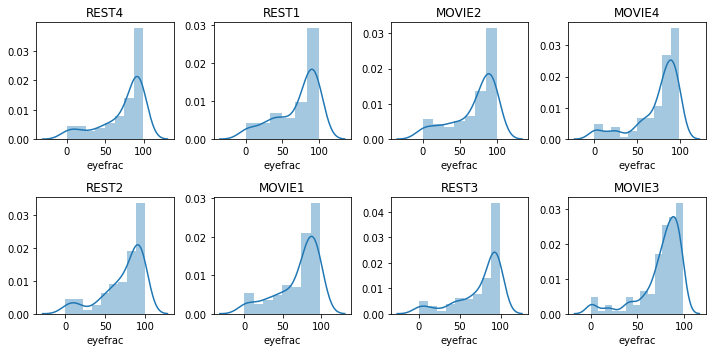

In [12]:
scans = eye_data["scan"].unique()

fig, axes = plt.subplots(2,4, figsize=(10,5))

for s,scan in enumerate(scans):
    ax = axes.flatten()[s]
    sns.distplot(eye_data[eye_data["scan"]==scan]["eyefrac"], ax=ax)
    ax.set_title(scan)

fig.tight_layout()

In [13]:
print(eye_data[eye_data["scan"]=="REST1"]["eyefrac"].shape)
print(eye_data[eye_data["scan"]=="MOVIE1"]["eyefrac"].shape)

(140,)
(162,)


In [14]:
eye_data_wide = eye_data.pivot(index="subject", columns="scan")["eyefrac"]
eye_data_wide.head()

scan,MOVIE1,MOVIE2,MOVIE3,MOVIE4,REST1,REST2,REST3,REST4
subject,,,,,,,,
100610,94.607,97.712,96.831,94.795,94.750,87.535,98.224,96.191
102311,4.053,0.730,77.814,64.550,NaN,61.934,75.340,62.915
102816,9.079,16.654,17.774,12.486,20.504,2.217,18.722,4.686
104416,19.093,46.095,66.301,77.142,0.067,72.633,80.533,55.131
105923,96.024,96.216,96.472,96.636,63.399,83.802,95.454,95.234


In [15]:
eye_data_wide[runs_of_interest]
print(len(eye_data_wide))
eye_data_wide.head()

166


scan,MOVIE1,MOVIE2,MOVIE3,MOVIE4,REST1,REST2,REST3,REST4
subject,,,,,,,,
100610,94.607,97.712,96.831,94.795,94.750,87.535,98.224,96.191
102311,4.053,0.730,77.814,64.550,NaN,61.934,75.340,62.915
102816,9.079,16.654,17.774,12.486,20.504,2.217,18.722,4.686
104416,19.093,46.095,66.301,77.142,0.067,72.633,80.533,55.131
105923,96.024,96.216,96.472,96.636,63.399,83.802,95.454,95.234


In [16]:
eye_data_wide[runs_of_interest].isna().sum()

scan
REST1     26
MOVIE1     4
MOVIE2     5
REST4     21
MOVIE3     5
MOVIE4     4
dtype: int64

In [17]:
eye_data_wide[runs_of_interest].count().sum()

931

In [18]:
plt.rcParams.update({'font.size': 20})

Performing paired t-test on pair: ('REST1', 'MOVIE1') stat=-1.48e+00 p-value=1.42e-01 df = 139
Performing paired t-test on pair: ('REST1', 'MOVIE2') stat=-5.47e-01 p-value=5.85e-01 df = 138
pvalues: [0.14235474913336438, 0.5850218767092321]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST1 v.s. MOVIE1: Custom statistical test, P_val:1.424e-01
REST1 v.s. MOVIE2: Custom statistical test, P_val:5.850e-01
Performing paired t-test on pair: ('REST4', 'MOVIE3') stat=-2.17e+00 p-value=3.20e-02 df = 143
Performing paired t-test on pair: ('REST4', 'MOVIE4') stat=-1.16e+00 p-value=2.50e-01 df = 144
pvalues: [0.032002703399434416, 0.24980662203726384]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST4 v.s. MOVIE3: Custom statistical test, P_val:3.200e-02
REST4 v.

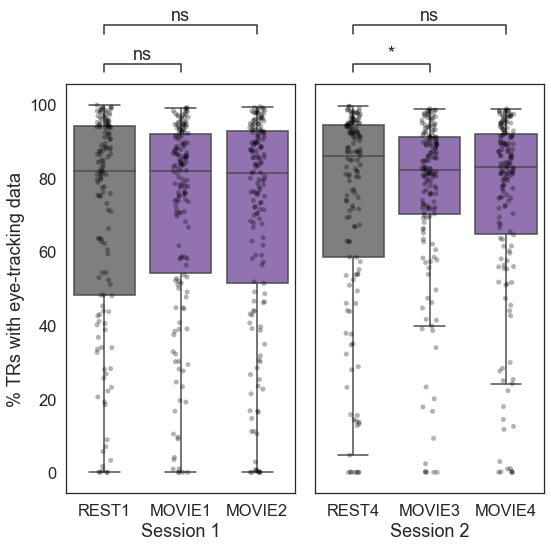

In [18]:
scan_order = ['REST1',
        'MOVIE1',
        'MOVIE2',
#        'REST2',
#        'REST3',
        'REST4',
        'MOVIE3',        
        'MOVIE4',
        ]

my_palette = {"REST1": "tab:gray", 
              "REST2": "tab:gray",
              "REST3": "tab:gray",
              "REST4": "tab:gray",
              "MOVIE1": "tab:purple",
              "MOVIE2": "tab:purple",
              "MOVIE3": "tab:purple",
              "MOVIE4": "tab:purple",
             }

# Plot group average
data = eye_data_wide
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,8), sharey=True)

# Do session 1
ax = ax1
order1 = ["REST1", "MOVIE1", "MOVIE2"]
sns.boxplot(data=data, 
              order=order1,
              palette=my_palette,
              ax=ax,
            showfliers=False
            ),
sns.stripplot(data=data, 
              ax=ax1,
             color="black", alpha = 0.3,
            order = order1,
             )

box_pairs=[("REST1", "MOVIE1"), ("REST1", "MOVIE2")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = data[pair[0]]
    data2 = data[pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df = {}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)
test_results = add_stat_annotation(ax, data=data, order=order1,
                                  box_pairs=[("REST1", "MOVIE1"), ("REST1", "MOVIE2")],
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  )

# Do session 2
ax = ax2
order2 = ["REST4", "MOVIE3", "MOVIE4"]
sns.boxplot(data=data, 
              order=order2,
              palette=my_palette,
              ax=ax,
            showfliers=False
            ),
sns.stripplot(data=data, 
              ax=ax,
             color="black", alpha = 0.3,
            order = order2,
             )

box_pairs=[("REST4", "MOVIE3"), ("REST4", "MOVIE4")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = data[pair[0]]
    data2 = data[pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df = {}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)
test_results = add_stat_annotation(ax, data=data, order=order2,
                                  box_pairs=box_pairs,
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  )

sns.set(font_scale=1.5, style="white")
ax1.set_ylabel("% TRs with eye-tracking data")
ax1.set_xlabel('Session 1')
ax2.set_xlabel('Session 2')
ax2.yaxis.label.set_visible(False)

fig.tight_layout()
plt.savefig('WholeRunResults_pctTRwEyeTrackingData.jpg', dpi=300)

In [19]:
eye_data_long = pd.melt(eye_data_wide.reset_index(), id_vars='subject', var_name='scan', value_name='eyefrac')
eye_data_long.set_index('subject', inplace=True)
eye_data_long.head()

,scan,eyefrac
subject,,
100610,MOVIE1,94.607
102311,MOVIE1,4.053
102816,MOVIE1,9.079
104416,MOVIE1,19.093
105923,MOVIE1,96.024


NameError: name 'order1' is not defined

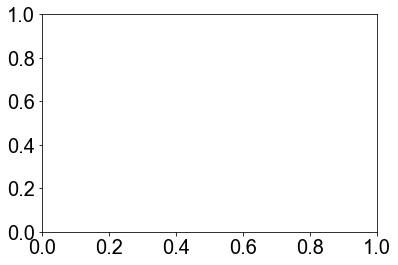

In [20]:
fig, ax = plt.subplots()

sns.set(style="ticks", rc={"lines.linewidth": 0.3})

for subj in eye_data_long.index.unique():
    sns.pointplot(x="scan", y="eyefrac", data=eye_data_long.loc[subj,:], order=order1, color='lightgray', dodge=True)
    
sns.boxplot(data=eye_data, 
              x='scan', y = 'eyefrac',
              order=order1,
              palette=my_palette,
              ax=ax,
            showfliers=False
            ),

This is all across subjects...need to do within subjects...

In [21]:
eye_data_wide = eye_data.pivot(index="subject", columns="scan")["eyefrac"]

x = eye_data_wide["REST4"]
y = eye_data_wide["MOVIE3"]

nas = np.logical_or(np.isnan(x), np.isnan(y))

sp.stats.ttest_rel(x[~nas], y[~nas])

Ttest_relResult(statistic=-2.165565157796029, pvalue=0.032002703399434416)

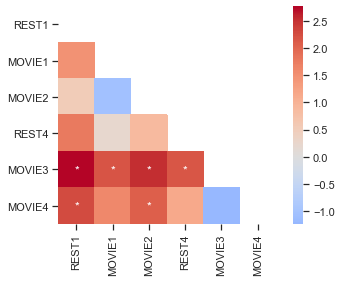

In [22]:
ttests = pd.DataFrame(index=scan_order, columns=scan_order)
pvals = pd.DataFrame(index=scan_order, columns=scan_order)

for c1,cond1 in enumerate(scan_order):
    for c2,cond2 in enumerate(scan_order):
        if c1 > c2:
            
            x = eye_data_wide[cond1]
            y = eye_data_wide[cond2]
            
            nas = np.logical_or(np.isnan(x), np.isnan(y))
            
            t, p = sp.stats.ttest_rel(x[~nas], y[~nas])
            ttests.loc[cond1, cond2] = t
            pvals.loc[cond1, cond2] = p

fig, ax = plt.subplots()
thresh = 0.05

mask = np.zeros_like(ttests)
mask[np.triu_indices_from(mask)] = True

labels = pvals.copy()
labels[labels.isnull()]=1
labels = labels.apply(lambda x: ['*' if y < thresh else '' for y in x])

sns.heatmap(ttests.fillna(0), 
            mask=mask, 
            annot=labels, 
            fmt='',
            center=0, 
            cmap='coolwarm',
            ax=ax, 
            square=True)

In [23]:
eye_data_long = pd.melt(eye_data_wide.reset_index(), id_vars='subject', var_name='scan', value_name='eyefrac')
eye_data_long.set_index('subject', inplace=True)
eye_data_long.head()

,scan,eyefrac
subject,,
100610,MOVIE1,94.607
102311,MOVIE1,4.053
102816,MOVIE1,9.079
104416,MOVIE1,19.093
105923,MOVIE1,96.024


### This could be masking true scan-condition differences just bc the eye tracker sucked in general. What if we limit it to scans that had at least X% of data tracked?

In [24]:
print(eye_data_wide.shape)
print((eye_data_wide > 50).sum())

(166, 8)
scan
MOVIE1    129
MOVIE2    121
MOVIE3    140
MOVIE4    139
REST1     104
REST2     116
REST3     117
REST4     117
dtype: int64


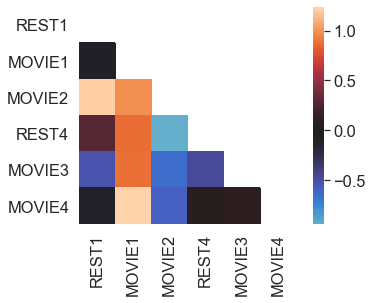

In [20]:
thresh = 50

ttests = pd.DataFrame(index=scan_order, columns=scan_order)
pvals = pd.DataFrame(index=scan_order, columns=scan_order)

for c1,cond1 in enumerate(scan_order):
    for c2,cond2 in enumerate(scan_order):
        if c1 > c2:
            
            x = eye_data_wide[cond1]
            y = eye_data_wide[cond2]
            
            xn = np.logical_or(np.isnan(x), x<thresh).values
            yn = np.logical_or(np.isnan(y), y<thresh).values
            nas = np.logical_or(xn, yn)
            
            t, p = sp.stats.ttest_rel(x[~nas], y[~nas])
            ttests.loc[cond1, cond2] = t
            pvals.loc[cond1, cond2] = p

fig, ax = plt.subplots()
thresh = 0.05

mask = np.zeros_like(ttests)
mask[np.triu_indices_from(mask)] = True

labels = pvals.copy()
labels[labels.isnull()]=1
labels = labels.apply(lambda x: ['*' if y < thresh else '' for y in x])

sns.heatmap(ttests.fillna(0), 
            mask=mask, 
            annot=labels, 
            fmt='',
            center=0, 
            ax=ax, 
            square=True)

## Read in the actual eye-tracking logs

Some subjects had a 500 Hz sampling rate instead of 1000:

In [22]:
eye_data["srate"].value_counts()

1000    1089
500      127
Name: srate, dtype: int64

In [23]:
video_tr_lookup = pd.read_csv('videoclip_tr_lookup.csv')
video_tr_lookup

,clipno_overall,run,clipno_in_run,clip_name,start_tr,stop_tr,duration,Unnamed: 7
0,1,MOVIE1_7T_AP,1,twomen,20,265,245,04:05
1,2,MOVIE1_7T_AP,2,bridgeville,285,506,221,03:41
2,3,MOVIE1_7T_AP,3,pockets,526,714,188,03:08
3,4,MOVIE1_7T_AP,4,overcome,735,798,63,01:03
4,5,MOVIE1_7T_AP,5,testretest1,818,901,83,01:23
5,6,MOVIE2_7T_PA,1,inception,20,248,228,03:48
6,7,MOVIE2_7T_PA,2,socialnet,267,526,259,04:19
7,8,MOVIE2_7T_PA,3,oceans,545,795,250,04:10
8,9,MOVIE2_7T_PA,4,testretest2,815,898,83,01:23
9,10,MOVIE3_7T_PA,1,flower,20,200,180,03:00


In [24]:
video_tr_lookup["clip_name"].values

array(['twomen', 'bridgeville', 'pockets', 'overcome', 'testretest1',
       'inception', 'socialnet', 'oceans', 'testretest2', 'flower',
       'hotel', 'garden', 'dreary', 'testretest3', 'homealone',
       'brokovich', 'starwars', 'testretest4'], dtype=object)

In [19]:
def read_in_eye_data(data_dir, subj, clip, start_stop_pads=(5,0), n_trs=None, verbose=False):
    
    long_to_short = {
        "MOVIE1": "MOV1",
        "MOVIE2": "MOV2",
        "MOVIE3": "MOV3",
        "MOVIE4": "MOV4",
        "REST1": "REST1",
        "REST2": "REST2",
        "REST3": "REST3",
        "REST4": "REST4",
    }
    
    end_tr_lookup = {
        "MOV1": 921,
        "MOV2": 918,
        "MOV3": 915,
        "MOV4": 901,
        "REST1": 900,
        "REST2": 900,
        "REST3": 900,
        "REST4": 900,
    }
    
    run_name_lookup = {
        "MOVIE1_7T_AP": "MOV1", 
        "MOVIE2_7T_PA": "MOV2", 
        "MOVIE3_7T_PA": "MOV3", 
        "MOVIE4_7T_AP": "MOV4"
    }
    
    
    if any(x in clip for x in ['REST','MOVIE']): # if this is a full run
        file = subj + '_7T_' + long_to_short[clip] + '_eyetrack'
        start_tr = 1
        if n_trs is None:
            end_tr = end_tr_lookup[long_to_short[clip]]
        elif n_trs is not None:
            end_tr = start_tr + n_trs
    else: # if this is an individual clip
        run_name = video_tr_lookup.query('clip_name==@clip')["run"].tolist()[0] # figure out which run this clip is in
        file = subj + '_7T_' + run_name_lookup[run_name] + '_eyetrack'
        start_tr = video_tr_lookup.loc[video_tr_lookup["clip_name"]==clip, "start_tr"].values[0]+start_stop_pads[0]
        if n_trs is None:
            end_tr = video_tr_lookup.loc[video_tr_lookup["clip_name"]==clip, "stop_tr"].values[0]+start_stop_pads[1]
        elif n_trs is not None:
            end_tr = start_tr + n_trs
    
    # Check if there is good data for this subject and this file
    try:
        summary = pd.read_csv(data_dir+file+'_summary.csv')
        if summary.shape==(1,16) and (summary["srate"]==1000).values[0]:

            if verbose is True:
                print("File is {}".format(file))
                print("Start-stop TRs are: {},{}".format(start_tr, end_tr))

            with open(data_dir+file+'.asc', 'r') as f:
                line_number=0
                for line in f:
                    if 'TRIALID ' + str(start_tr)+'\n' in line:
                        startline = line_number
                    if 'TRIALID ' + str(end_tr) in line:
                        endline = line_number
                    line_number +=1

            data = []

            try: # some files just don't seem to have TR triggers in them, leading to a 'startline referenced before assignment' error...
                with open(data_dir+file+'.asc', 'r') as f:
                    good_lines=0
                    for l,line in enumerate(f):
                        if l>startline and l<endline:
                            try:
                                float(line.split('\t')[0]) # if the first column is a timestamp...
                                line = [item.replace(' .', 'nan') for item in line.split('\t')[:4]] # ...first replace annoying periods denoting missing data points
                                data.append([float(x) for x in line]) # then make them into floats and append them
                                good_lines+=1
                            except:
                                pass
                if verbose is True:
                    print("Total good_lines: {}".format(good_lines))
                if good_lines>0:
                    return data
            
            except:
                pass
    except:
        pass

In [20]:
def pear_corr(x,y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return sp.stats.pearsonr(x[~nas], y[~nas])

### Let's read in for just the first 143 TRs for all subjects for all clips

The below cell only needs to be run ONCE, and it will take a while:

In [19]:
n_trs = 143

clip_list=video_tr_lookup["clip_name"].tolist()
subj_list = np.load('subj_list.npy', allow_pickle=True)

# Read in data...this step will take a while
data = {}

for clip in clip_list:
    print("---------Doing clip {}---------".format(clip))
    data[clip] = {}
    for s,subj in enumerate(subj_list):
        print("Doing subject {} of {}".format(s+1, len(subj_list)))
        tmp = read_in_eye_data(data_dir, subj, clip, n_trs=n_trs)
        if tmp is not None:
            data[clip][subj] = tmp
        else:
            pass

# For whatever reason this subject gives a lot of trouble, so we just get rid of them
data["inception"].pop("146937")
data["socialnet"].pop("146937")
data["oceans"].pop("146937")

# Create ISC matrices (one per clip) for each of the three data streams (x-pos, y-pos and pupil dilation) and save them to json files 
for name, col in list(zip(['xpos', 'ypos', 'pupil'],[1,2,3])):
    isc_matrices = {}
    for clip in clip_list:
        print(clip)
        min_n_samples = np.min([len(x) for x in data[clip].values()])
        max_n_samples = np.max([len(x) for x in data[clip].values()])
        print("Min, max n samples: {}, {}".format(min_n_samples, max_n_samples))
        tmp = pd.DataFrame([np.array(x)[:min_n_samples,col] for x in data[clip].values()]).T.corr().values
        np.fill_diagonal(tmp, np.nan)
        isc_matrices[clip] = tmp
        
    f_name = 'isc_matrices_' + name + '_trs-143.json'
    with open(f_name, 'wb') as fp:
        pickle.dump(isc_matrices, fp)

Creating data
---------Doing clip twomen---------
Doing subject 0 of 176
Doing subject 1 of 176
Doing subject 2 of 176
Doing subject 3 of 176
Doing subject 4 of 176
Doing subject 5 of 176
Doing subject 6 of 176
Doing subject 7 of 176
Doing subject 8 of 176
Doing subject 9 of 176
Doing subject 10 of 176
Doing subject 11 of 176
Doing subject 12 of 176
Doing subject 13 of 176
Doing subject 14 of 176
Doing subject 15 of 176
Doing subject 16 of 176
Doing subject 17 of 176
Doing subject 18 of 176
Doing subject 19 of 176
Doing subject 20 of 176
Doing subject 21 of 176
Doing subject 22 of 176
Doing subject 23 of 176
Doing subject 24 of 176
Doing subject 25 of 176
Doing subject 26 of 176
Doing subject 27 of 176
Doing subject 28 of 176
Doing subject 29 of 176
Doing subject 30 of 176
Doing subject 31 of 176
Doing subject 32 of 176
Doing subject 33 of 176
Doing subject 34 of 176
Doing subject 35 of 176
Doing subject 36 of 176
Doing subject 37 of 176
Doing subject 38 of 176
Doing subject 39 of 176


NameError: name 'json' is not defined

In [4]:
name = 'xpos'

f_name = 'isc_matrices_' + name + '_trs-143.json'
with open(f_name, 'rb') as f:
    isc_matrices = pickle.load(f)

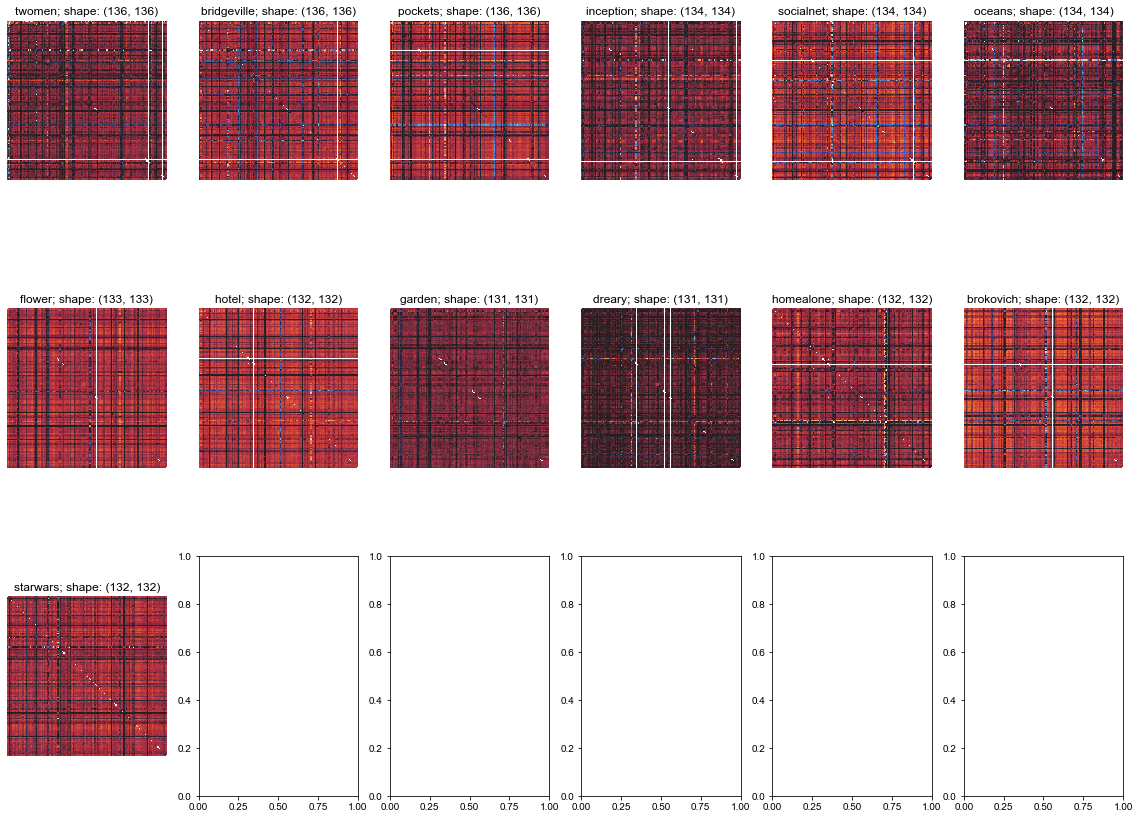

In [5]:
fig, axes = plt.subplots(3,6, figsize=(20,15))
sns.set(font_scale=1)

clip_list = list(isc_matrices.keys())

for c,clip in enumerate(clip_list):
    ax = axes.flatten()[c]
    sns.heatmap(isc_matrices[clip], center=0, ax=ax, square=True, vmin=-1, vmax=1, cbar=False)
    ax.set_title(clip + "; shape: {}".format(isc_matrices[clip].shape))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

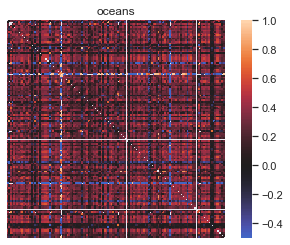

In [6]:
clip = "oceans"

fig, ax = plt.subplots()

sns.heatmap(isc_matrices[clip], center=0, ax=ax, square=True, vmin=-0.5, vmax=1, cbar=True)
ax.set_title(clip)

ax.set_xlabel('Subjects')
ax.set_ylabel('Subjects')

ax.xaxis.set_ticklabels('')
ax.yaxis.set_ticklabels('')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [9]:
clip = "socialnet"
print(clip)
iu1 = np.triu_indices_from(isc_matrices[clip])
print(len(iu1[0]))
print(np.isnan(isc_matrices[clip][iu1]).sum())
print((isc_matrices[clip][iu1] < 0).sum())

clip = "dreary"
print(clip)
iu1 = np.triu_indices_from(isc_matrices[clip])
print(np.isnan(isc_matrices[clip][iu1]).sum())
print((isc_matrices[clip][iu1] < 0).sum())

socialnet
9045
995
792
dreary
786
894


/Users/finnes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Users/finnes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


In [10]:
isc_stats = pd.DataFrame(index=clip_list, columns=["mean", "median", "std"])

for clip in clip_list:
    iu1 = np.triu_indices_from(isc_matrices[clip])
    
    off_diag = isc_matrices[clip][iu1]
    
    isc_stats.loc[clip, "mean"] = np.nanmean(off_diag)
    isc_stats.loc[clip, "median"] = np.nanmedian(off_diag)
    isc_stats.loc[clip, "std"] = np.nanstd(off_diag)

isc_stats

,mean,median,std
twomen,0.255063,0.293759,0.206386
bridgeville,0.311436,0.390193,0.247228
pockets,0.334872,0.402499,0.242987
inception,0.258059,0.290485,0.191301
socialnet,0.343584,0.409566,0.270362
oceans,0.208504,0.25756,0.244717
flower,0.384627,0.426622,0.188564
hotel,0.417298,0.47385,0.199208
garden,0.274388,0.306662,0.156933
dreary,0.161006,0.172085,0.153248


In [12]:
cogn_median_vals = pd.read_csv("cogn_median_val_trs-143.csv", squeeze=True).set_index("clip")
cogn_median_vals

,r_val
clip,
oceans,0.342261
dreary,0.040545
garden,0.182495
hotel,0.141923
inception,0.222143
brokovich,0.187331
starwars,0.211377
twomen,0.180369
pockets,0.216468


In [13]:
rename_dict = {
    "twomen": "two men",
    "oceans": "ocean's 11",
    "socialnet": "social net",
    "homealone": "home alone",
    "starwars": "star wars"
}

cogn_median_vals = cogn_median_vals.rename(index=rename_dict)
isc_stats = isc_stats.rename(index=rename_dict)

df 11
(0.05639109074188538, 0.8548154312856092)
SpearmanrResult(correlation=-0.06593406593406594, pvalue=0.8305423857560938)


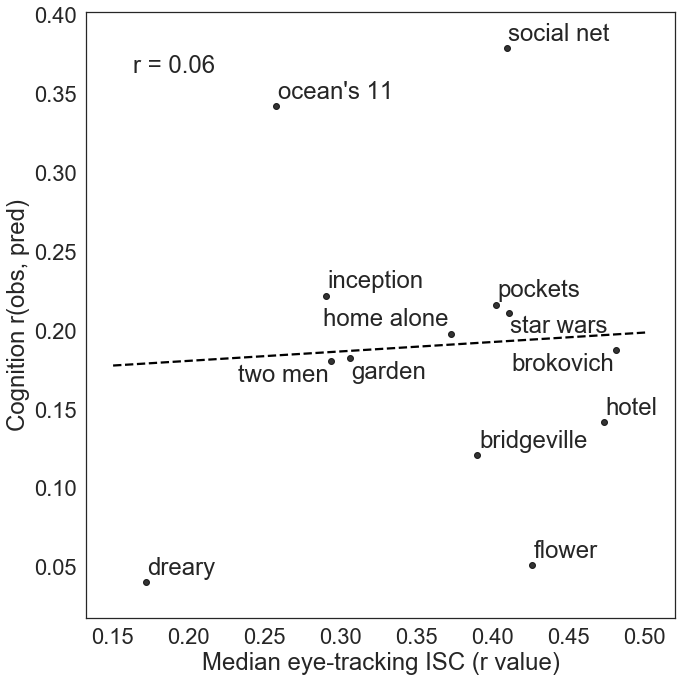

In [40]:
stat = "median"

x = isc_stats.loc[cogn_median_vals.index, stat]
y = cogn_median_vals.squeeze()

print("df {}".format(x.shape[0]-2))
print(sp.stats.pearsonr(x,y))
print(sp.stats.spearmanr(x,y))

r, p = sp.stats.pearsonr(x,y)

plt.rcParams.update({'font.size': 22})
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10,10),sharey=True)
sns.set(style="white", font_scale=2)

sns.regplot(x=x.values.astype(float), y=y.values.astype(float), color='black', truncate=False, line_kws={'linestyle': 'dashed'}, ci=None)
labels = [ax.annotate(txt, (x[i], y[i])) for i,txt in enumerate(x.index.values)]
adjust_text(labels)

ax.set_xlabel("Median eye-tracking ISC (r value)") # .format(stat))
ax.set_ylabel("Cognition r(obs, pred)")
ax.annotate(f"r = {r:.2f}", xy=(0.08, 0.9), xycoords='axes fraction')

fig.tight_layout()
# set_aspect_ratio(ax)

## Looking at blinks

In [25]:
blink_data_fname = 'blink_data_w_microsleeps.csv'
microsleep_length = 1000 # cutoff for microsleep (in ms)

if os.path.isfile(blink_data_fname):
    print("Loading blink data from preexisting file...")
    blink_data = pd.read_csv(blink_data_fname, dtype={'subject': 'str'})
    print("...done!")
    
else:
    print("Creating blink data from individual subject logs...")
    
    blink_data = pd.DataFrame(columns=["subject", "scan", "n_blinks", "mean_blink_dur", "median_blink_dur", "n_microsleeps"])

    for s,subj in enumerate(eye_data.subject.unique()):
        print("Doing subject {} of {}".format(s+1, len(eye_data.subject.unique())))
        for scan in ["REST1", "REST2", "REST3", "REST4", "MOV1", "MOV2", "MOV3", "MOV4"]:

            tmp = {}
            tmp["subject"] = subj
            tmp["scan"] = scan

            file = str(subj) + '_7T_' + scan + '_eyetrack.asc'

            with open(data_dir+file, 'r') as f:
                line_no=0
                n_blink_starts=0
                n_blink_ends=0
                blink_dur=[]
                for line in f:
                    line_no +=1
                    if 'SBLINK' in line:
                        n_blink_starts+=1
                    if 'EBLINK' in line:
                        n_blink_ends+=1
                        blink_dur.append(int(line.split()[-1]))

            tmp["n_blinks"] = n_blink_ends
            tmp["mean_blink_dur"] = np.mean(blink_dur)
            tmp["median_blink_dur"] = np.median(blink_dur)
            tmp["n_microsleeps"] = (np.array(blink_dur) > microsleep_length).sum()

            blink_data = blink_data.append(tmp, ignore_index=True)

    blink_data.head()
    blink_data.to_csv(blink_data_fname, index=False)

Loading blink data from preexisting file...
...done!


In [26]:
blink_data = blink_data.replace(short_to_long)

In [27]:
blink_data.head()

,subject,scan,n_blinks,mean_blink_dur,median_blink_dur,n_microsleeps
0,173334,REST1,540,898.109259,175.5,91
1,173334,REST2,627,1085.492823,20.0,71
2,173334,REST3,404,1757.376238,21.5,60
3,173334,REST4,369,1118.775068,232.0,91
4,173334,MOVIE1,1084,311.567343,32.0,62


In [28]:
print("Found blink data for {} subjects and {} scans".format(len(blink_data.subject.unique()), blink_data.shape[0]))

# Remove rows with NaNs
blink_data = blink_data[~blink_data.isnull().any(axis=1)]
print("After removing scans with no blink data, {} subjects and {} scans remain".format(len(blink_data.subject.unique()), blink_data.shape[0]))

Found blink data for 166 subjects and 1328 scans
After removing scans with no blink data, 166 subjects and 1216 scans remain


It looks like for some files, there was one blink recorded for basically the whole duration of the scan, which is really throwing off the numbers. Let's try liming this to scans where morethan 1 blink was detected

In [29]:
blink_data = blink_data[(blink_data["n_blinks"]>10) & (blink_data["n_blinks"]<3000)]
print("After removing scans with way too few or way too many blinks, {} subjects and {} scans remain".format(len(blink_data.subject.unique()), blink_data.shape[0]))

blink_data = blink_data[(blink_data["median_blink_dur"] < 10000)]
print("After removing scans with an unreasonable value for median_blink_dur, {} subjects and {} scans remain".format(len(blink_data.subject.unique()), blink_data.shape[0]))

After removing scans with way too few or way too many blinks, 165 subjects and 1174 scans remain
After removing scans with an unreasonable value for median_blink_dur, 165 subjects and 1173 scans remain


Convert raw number of blinks to blink rate:

In [30]:
run_length_lookup = {
        "MOVIE1": 921,
        "MOVIE2": 918,
        "MOVIE3": 915,
        "MOVIE4": 901,
        "REST1": 900,
        "REST2": 900,
        "REST3": 900,
        "REST4": 900,
    }

blink_rate = []

for index, row in blink_data.iterrows():
    scan = row["scan"]
    blink_rate.append(row["n_blinks"]/(run_length_lookup[scan]/60))

    
blink_data["blink_rate"]= blink_rate

In [31]:
blink_data.head()

,subject,scan,n_blinks,mean_blink_dur,median_blink_dur,n_microsleeps,blink_rate
0,173334,REST1,540,898.109259,175.5,91,36.000000
1,173334,REST2,627,1085.492823,20.0,71,41.800000
2,173334,REST3,404,1757.376238,21.5,60,26.933333
3,173334,REST4,369,1118.775068,232.0,91,24.600000
4,173334,MOVIE1,1084,311.567343,32.0,62,70.618893


In [32]:
blink_data_wide = blink_data.pivot(index="subject", columns="scan")
blink_data_wide.index = blink_data_wide.index.map(str)
print(blink_data_wide.shape)
blink_data_wide.head()

(165, 40)


n_blinks                                                   \
scan      MOVIE1 MOVIE2 MOVIE3 MOVIE4  REST1  REST2  REST3  REST4   
subject                                                             
100610     311.0  154.0  190.0  250.0  307.0  357.0  117.0  209.0   
102311     255.0   36.0  573.0  416.0    NaN  364.0  419.0  557.0   
102816     193.0  293.0  405.0  339.0  354.0   72.0  309.0  107.0   
104416     951.0  894.0  684.0  727.0    NaN  663.0  667.0  670.0   
105923     198.0  153.0  103.0   96.0  210.0  185.0  145.0  160.0   

        mean_blink_dur                ... n_microsleeps       blink_rate  \
scan            MOVIE1        MOVIE2  ...         REST3 REST4     MOVIE1   
subject                               ...                                  
100610      179.327974    152.740260  ...           1.0   0.0  20.260586   
102311     3907.498039  27848.527778  ...          54.0  58.0  16.612378   
102816     4780.756477   2860.576792  ...         127.0  42.0  12.573290   
104416      893.257624    631.128635  ...           4.0  65.0  61.954397   
105923      200.676768    242.705882  ...           9.0   8.0  12.899023   

                                                                           \
scan        MOVIE2     MOVIE3     MOVIE4      REST1      REST2      REST3   
subject                                                                     
100610   10.065359  12.459016  16.648169  20.466667  23.800000   7.800000   
102311    2.352941  37.573770  27.702553        NaN  24.266667  27.933333   
102816   19.150327  26.557377  22.574917  23.600000   4.800000  20.600000   
104416   58.431373  44.852459  48.412875        NaN  44.200000  44.466667   
105923   10.000000   6.754098   6.392897  14.000000  12.333333   9.666667   

                    
scan         REST4  
subject             
100610   13.933333  
102311   37.133333  
102816    7.133333  
104416   44.666667  
105923   10.666667  

[5 rows x 40 columns]

In [33]:
behav_data = pd.read_csv('/Users/finnes/Documents/HCP_7T/unres_behav_data.csv', dtype={'Subject': 'str'})
behav_data.set_index("Subject", inplace=True)
print(behav_data.shape)
behav_data.head()

(184, 382)


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,2.0,122.25,110.45,0,38.6,84.84,85.31,1.92,1,1.88
102311,S500,Q06,F,26-30,True,1,1,4,100.0,True,...,4.4,122.25,110.45,1,52.2,98.31,99.06,1.80,0,1.80
102816,Q3,Q03,F,26-30,True,1,1,4,100.0,True,...,5.2,122.25,111.41,1,52.6,98.31,97.68,1.72,1,1.68
104416,S900,Q09,F,31-35,True,2,2,4,100.0,True,...,2.8,101.12,87.11,0,38.6,95.36,93.48,1.92,1,1.88
105923,MEG2,Q07,F,31-35,True,2,2,4,100.0,True,...,5.2,122.25,111.41,0,38.6,97.26,96.41,1.88,1,1.84


SpearmanrResult(correlation=-0.08569343023096587, pvalue=0.289058062719275)


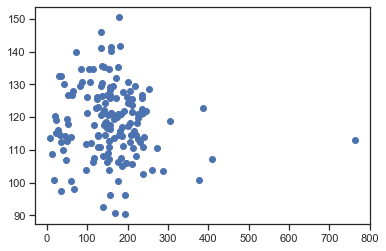

In [34]:
x = blink_data_wide["median_blink_dur"]["MOVIE3"]
y = behav_data.loc[blink_data_wide.index, "ReadEng_Unadj"]

print(sp.stats.spearmanr(x,y, nan_policy='omit'))
plt.scatter(x,y)

In [35]:
blink_data.groupby("scan")["blink_rate"].median()

scan
MOVIE1    33.485342
MOVIE2    32.549020
MOVIE3    32.852459
MOVIE4    33.296337
REST1     22.300000
REST2     23.866667
REST3     23.600000
REST4     25.133333
Name: blink_rate, dtype: float64

In [64]:
blink_data.groupby("scan")["blink_rate"].mean()

scan
MOVIE1    39.988455
MOVIE2    36.285822
MOVIE3    37.383395
MOVIE4    37.441625
REST1     28.854726
REST2     31.407194
REST3     29.690024
REST4     30.266667
Name: blink_rate, dtype: float64

In [65]:
blink_data.groupby("scan")["blink_rate"].std()

scan
MOVIE1    29.656510
MOVIE2    26.699044
MOVIE3    26.487557
MOVIE4    29.759680
REST1     23.216780
REST2     28.360949
REST3     24.838704
REST4     21.093017
Name: blink_rate, dtype: float64

In [66]:
blink_data.groupby("scan")["median_blink_dur"].median()

scan
MOVIE1    149.5
MOVIE2    152.0
MOVIE3    155.5
MOVIE4    146.0
REST1     188.5
REST2     188.0
REST3     177.0
REST4     185.0
Name: median_blink_dur, dtype: float64

In [67]:
blink_data.groupby("scan")["n_microsleeps"].median()

scan
MOVIE1    21
MOVIE2    15
MOVIE3    16
MOVIE4    17
REST1     18
REST2     21
REST3      7
REST4     10
Name: n_microsleeps, dtype: int64

In [62]:
corr_table = blink_data.groupby("scan")["blink_rate", "median_blink_dur", "n_microsleeps"].corr()
corr_table = corr_table.loc[runs_of_interest]
corr_table

/Users/finnes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


blink_rate  median_blink_dur  n_microsleeps
scan                                                                
MOVIE1 blink_rate          1.000000         -0.312291       0.435590
       median_blink_dur   -0.312291          1.000000      -0.046815
       n_microsleeps       0.435590         -0.046815       1.000000
MOVIE2 blink_rate          1.000000         -0.243762       0.464520
       median_blink_dur   -0.243762          1.000000       0.048765
       n_microsleeps       0.464520          0.048765       1.000000
MOVIE3 blink_rate          1.000000         -0.297931       0.407524
       median_blink_dur   -0.297931          1.000000       0.142203
       n_microsleeps       0.407524          0.142203       1.000000
MOVIE4 blink_rate          1.000000         -0.320148       0.329554
       median_blink_dur   -0.320148          1.000000       0.061246
       n_microsleeps       0.329554          0.061246       1.000000
REST1  blink_rate          1.000000         -0.220858       0.331868
       median_blink_dur   -0.220858          1.000000       0.227748
       n_microsleeps       0.331868          0.227748       1.000000
REST4  blink_rate          1.000000         -0.140847       0.506924
       median_blink_dur   -0.140847          1.000000       0.098291
       n_microsleeps       0.506924          0.098291       1.000000

In [68]:
corr_table.mean(level=1)

,blink_rate,median_blink_dur,n_microsleeps
blink_rate,1.000000,-0.255973,0.412663
median_blink_dur,-0.255973,1.000000,0.088573
n_microsleeps,0.412663,0.088573,1.000000


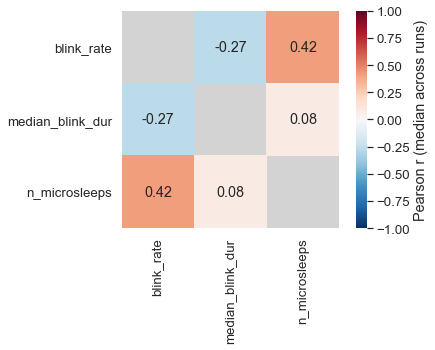

In [87]:
corr_table_median = corr_table.median(level=1)
np.fill_diagonal(corr_table_median.values, np.nan)

sns.set(font_scale=1.2)
g = sns.heatmap(corr_table_median, center=0, vmin=-1, vmax=1, 
                cmap='RdBu_r', cbar_kws={'label': 'Pearson r (median across runs)'},
                square=True, annot=True)
g.set_facecolor("lightgray")

Performing paired t-test on pair: ('REST1', 'MOVIE1') stat=-1.21e+00 p-value=2.28e-01 df=133
Performing paired t-test on pair: ('REST1', 'MOVIE2') stat=-2.17e-01 p-value=8.28e-01 df=132
pvalues: [0.22789020462146733, 0.8282284873930585]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST1 v.s. MOVIE1: Custom statistical test, P_val:2.279e-01
REST1 v.s. MOVIE2: Custom statistical test, P_val:8.282e-01
Performing paired t-test on pair: ('REST4', 'MOVIE3') stat=9.83e-01 p-value=3.27e-01 df=136
Performing paired t-test on pair: ('REST4', 'MOVIE4') stat=7.34e-01 p-value=4.64e-01 df=136
pvalues: [0.32741318748214454, 0.4640004754805961]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

REST4 v.s. MOVIE3: Custom statistical test, P_val:3.274e-01
REST4 v.s. MOVIE4: C

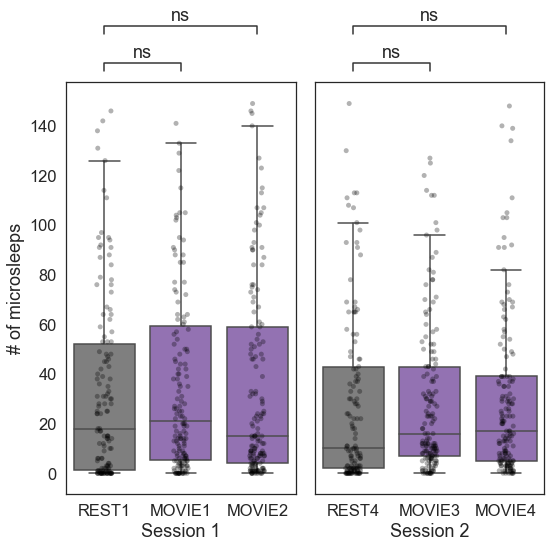

In [72]:
# Plot distributions
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,8), sharey=True)

data = blink_data
x = 'scan'
y = 'n_microsleeps' # median_blink_dur, blink_rate, n_microsleeps
ylabel = "# of microsleeps"
outlier_cutoff = 150 # for median_blink_dir, 500 is a good one; for n_blinks, 1600 is a good one; for blink_rate, 150 is a good one
palette = my_palette


# -------------------------------------------------------------------------------------
# Do session 1
ax = ax1
order1 = ["REST1", "MOVIE1", "MOVIE2"]
sns.boxplot(data=data, x=x, y=y,
              order=order1,
              palette = palette,
              ax=ax,
              showfliers=False # hide outliers
             )
sns.stripplot(data=data[data[y] < outlier_cutoff], x=x, y=y,
              order=order1,
              color='black', alpha=0.3,
              ax=ax
             )

box_pairs=[("REST1", "MOVIE1"), ("REST1", "MOVIE2")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = blink_data_wide.loc[:,y][pair[0]]
    data2 = blink_data_wide.loc[:,y][pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df={}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)

test_results = add_stat_annotation(ax, data=data, x=x, y=y, order=order1,
                                  box_pairs=box_pairs,
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  # line_offset_to_box=-0.5
                                  )

# Do session 2
ax = ax2
order2 = ["REST4", "MOVIE3", "MOVIE4"]

sns.boxplot(data=data, x=x, y=y,
              order=order2,
              palette = palette,
              ax=ax,
              showfliers=False # hide outliers
             )
sns.stripplot(data=data[data[y] < outlier_cutoff], x=x, y=y,
              order=order2,
              color='black', alpha=0.3,
              ax=ax
             )

box_pairs=[("REST4", "MOVIE3"), ("REST4", "MOVIE4")]
test_short_name = 'paired t-test'
pvalues = []
for pair in box_pairs:
    data1 = blink_data_wide.loc[:,y][pair[0]]
    data2 = blink_data_wide.loc[:,y][pair[1]]
    nas = np.logical_or(np.isnan(data1), np.isnan(data2))
    stat, p = sp.stats.ttest_rel(data1[~nas], data2[~nas])
    df = data1[~nas].shape[0]-1
    print("Performing paired t-test on pair:",
          pair, "stat={:.2e} p-value={:.2e} df={}".format(stat, p, df))
    pvalues.append(p)
print("pvalues:", pvalues)
test_results = add_stat_annotation(ax, data=data, x=x, y=y,order=order2,
                                  box_pairs=box_pairs,
                                  perform_stat_test=False, pvalues=pvalues,
                                  test_short_name=test_short_name, loc='outside'
                                  )

sns.set(font_scale=1.5, style="white")

ax1.set_xlabel("Session 1")
ax2.set_xlabel("Session 2")

ax1.set_ylabel(ylabel)
ax2.yaxis.label.set_visible(False)

fig.tight_layout()
plt.savefig(''.join(['figures/', y, '.jpg']), dpi=300)

In [38]:
order1

['REST4', 'MOVIE3', 'MOVIE4']

In [424]:
blink_data_wide = blink_data.pivot(index="subject", columns="scan")
print(blink_data_wide.shape)
blink_data_wide.head()

(165, 24)


n_blinks                                                   \
scan         MOV1   MOV2   MOV3   MOV4  REST1  REST2  REST3  REST4   
subject                                                              
100610.0    311.0  154.0  190.0  250.0  307.0  357.0  117.0  209.0   
102311.0    255.0   36.0  573.0  416.0    NaN  364.0  419.0  557.0   
102816.0    193.0  293.0  405.0  339.0  354.0   72.0  309.0  107.0   
104416.0    951.0  894.0  684.0  727.0    NaN  663.0  667.0  670.0   
105923.0    198.0  153.0  103.0   96.0  210.0  185.0  145.0  160.0   

         mean_blink_dur                ...                              \
scan               MOV1          MOV2  ...          REST3        REST4   
subject                                ...                               
100610.0     179.327974    152.740260  ...     158.025641   184.411483   
102311.0    3907.498039  27848.527780  ...     686.250597   745.052065   
102816.0    4780.756477   2860.576792  ...    2867.330097  8827.196262   
104416.0     893.257624    631.128635  ...     299.248876   663.995522   
105923.0     200.676768    242.705882  ...     299.420690   287.475000   

         median_blink_dur                                                    
scan                 MOV1   MOV2   MOV3   MOV4  REST1   REST2  REST3  REST4  
subject                                                                      
100610.0            148.0  145.5  158.0  181.0  137.0   173.0  156.0  182.0  
102311.0             51.0   37.5  126.0  185.0    NaN   329.0  243.0   55.0  
102816.0            562.0  409.0  377.0  179.0  372.5  1009.0  908.0  540.0  
104416.0            262.0  317.5  252.0  220.0    NaN   274.0  257.0  361.0  
105923.0            160.0  157.0  165.0  152.0  261.0   243.0  168.0  178.0  

[5 rows x 24 columns]

In [76]:
stat = "blink_rate"

x = blink_data_wide[stat]["REST1"]
y = blink_data_wide[stat]["MOVIE2"]

nas = np.logical_or(np.isnan(x), np.isnan(y))

sp.stats.ttest_rel(x[~nas], y[~nas])

Ttest_relResult(statistic=-3.1430725235930255, pvalue=0.0020649326380924008)

In [414]:
stat = "median_blink_dur"

x = blink_data_wide[stat]["REST1"]
y = blink_data_wide[stat]["MOV2"]

nas = np.logical_or(x.isnull(), y.isnull())

sp.stats.ttest_rel(x[~nas], y[~nas])

Ttest_relResult(statistic=2.7900261800685957, pvalue=0.006051489066839135)

Text(0.5, 1, 'median_blink_dur')

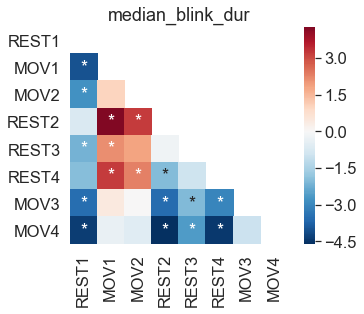

In [435]:
stat = "median_blink_dur"

ttests = pd.DataFrame(index=scan_order, columns=scan_order)
pvals = pd.DataFrame(index=scan_order, columns=scan_order)

for c1,cond1 in enumerate(scan_order):
    for c2,cond2 in enumerate(scan_order):
        if c1 > c2:
            
            x = blink_data_wide[stat][cond1]
            y = blink_data_wide[stat][cond2]
            
            nas = np.logical_or(np.isnan(x), np.isnan(y))
            
            t, p = sp.stats.ttest_rel(x[~nas], y[~nas])
            ttests.loc[cond1, cond2] = t
            pvals.loc[cond1, cond2] = p

fig, ax = plt.subplots()
thresh = 0.05

mask = np.zeros_like(ttests)
mask[np.triu_indices_from(mask)] = True

labels = pvals.copy()
labels[labels.isnull()]=1
labels = labels.apply(lambda x: ['*' if y < thresh else '' for y in x])

sns.heatmap(ttests.fillna(0), 
            mask=mask, 
            annot=labels, 
            fmt='',
            cmap='RdBu_r',
            center=0, 
            ax=ax, 
            square=True)

ax.set_title(stat)